<div align="center">

###### Lab 2

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 2: Predicting Heart Disease with Deep Learning

</div>

### Introduction

In the realm of healthcare, early detection and accurate prediction of diseases play a crucial role in patient care and management. Heart disease remains one of the leading causes of mortality worldwide, making the development of effective diagnostic tools essential. This lab leverages deep learning to predict the presence of heart disease in patients using a subset of 14 key attributes from the Cleveland Heart Disease Database. The objective is to explore and apply deep learning techniques to distinguish between the presence and absence of heart disease based on clinical parameters.

Throughout this lab, you'll engage with the following key activities:
- Use [Pandas](https://pandas.pydata.org) to process the CSV files.
- Use [PyTorch](https://pytorch.org) to build an Artificial Neural Network (ANN) to fit the dataset.
- Evaluate the performance of the trained model to understand its accuracy.

### Attribute Information

1. age: Age of the patient in years
2. sex: (Male/Female)
3. cp: Chest pain type (4 types: low, medium, high, and severe)
4. trestbps: Resting blood pressure
5. chol: Serum cholesterol in mg/dl
6. fbs: Fasting blood sugar > 120 mg/dl
7. restecg: Resting electrocardiographic results (values 0,1,2)
8. thalach: Maximum heart rate achieved
9. exang: Exercise induced angina
10. oldpeak: Oldpeak = ST depression induced by exercise relative to rest
11. slope: The slope of the peak exercise ST segment
12. ca: Number of major vessels (0-3) colored by fluoroscopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversible defect
14. target: target have disease or not (1=yes, 0=no)

### References
- [UCI Heart Disease Data](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data) for the dataset we use in this lab.


# Utils

## Get Training Data

In [9]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

df = pd.read_csv('heart_dataset_train_all.csv')

# one hot encoding
sex_description = {
    'Male': 0,
    'Female': 1,
}
df.loc[:, 'sex'] = df['sex'].map(sex_description)

# Mapping 'cp' (chest pain) descriptions to numbers
pain_description = {
    'low': 0,
    'medium': 1,
    'high': 2,
    'severe': 3
}
df.loc[:, 'cp'] = df['cp'].map(pain_description)

df = df.dropna()
# split train, validation data
np_data = df.values
print(np_data.shape)
split_point = int(np_data.shape[0]*0.7)

np.random.shuffle(np_data)

x_train = np_data[:split_point, :13]
y_train = np_data[:split_point, 13]
x_val = np_data[split_point:, :13]
y_val = np_data[split_point:, 13]

# trasform to Dataloader
x_train = np.array(x_train, dtype=float)
x_train = torch.from_numpy(x_train).float()
y_train = np.array(y_train, dtype=int)
y_train = torch.from_numpy(y_train).long()

x_val = np.array(x_val, dtype=float)
x_val = torch.from_numpy(x_val).float()
y_val = np.array(y_val, dtype=int)
y_val = torch.from_numpy(y_val).long()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

(270, 14)
Number of samples in train and validation are 189 and 81.


C:\Users\paddy\AppData\Local\Temp\ipykernel_25764\4057028464.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'sex'] = df['sex'].map(sex_description)
C:\Users\paddy\AppData\Local\Temp\ipykernel_25764\4057028464.py:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'cp'] = df['cp'].map(pain_description)


## Get Testing Data

In [10]:
test_data = pd.read_csv('heart_dataset_test.csv')
test_data = test_data.values
# Convert to PyTorch tensors
x_test = torch.from_numpy(test_data[:, :13]).float()
y_test = torch.from_numpy(test_data[:, 13]).long()

# Create datasets
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [3]:
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(13, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        return self.model(x)

## Train Function

In [4]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm
from typing import List, Tuple


epochs = 100


# print(model)



# model = Model().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

def experiment(model,
               train_loader,
               val_loader,
               test_loader,
               lr_scheduler,
               optimizer,
               epochs=100)->Tuple[List, int]:
    """
    Train & Evaluate the Model
    Args:
        train_loader, val_loader, test_loader -> Data
        lr_scheduler, optimizer -> hyperparameters adjustment
        
    Returns:
        history: [train_losses, val_losses, train_accuracies, val_accuracies, lrs]
        test_accuracy
    """
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    lrs = []
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    best_val_acc = -1
    for epoch in tqdm(range(epochs)):
        # Training
        model.train()
        total_loss = 0.0
        train_correct = 0
        total_train_samples = 0

        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)

            outputs = model(features)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_predicted = outputs.argmax(-1)
            train_correct += (train_predicted == labels).sum().item()
            total_train_samples += labels.size(0)
            
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        # Learning rate update
        lr_scheduler.step()

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = 100. * train_correct / total_train_samples

        # Validation
        model.eval()
        total_val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = labels.to(device)

                outputs = model(features)

                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                predicted = outputs.argmax(-1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100. * correct / total

        # Checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'model_classification.pth')

        # Store performance
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
    #Test Section
    # Load the trained weights
    model.load_state_dict(torch.load('model_classification.pth'))

    # Set the model to evaluation mode
    model.eval()

    test_correct = 0
    total_test_loss = 0.0
    test_total = 0

    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)

            outputs = model(features)
            
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
            
            predicted = outputs.argmax(-1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            
    test_loss = total_test_loss / len(test_loader)        
    test_accuracy = 100. * test_correct / test_total
    print(f'Test accuracy is {test_accuracy}%')
    
    history = [train_losses, val_losses, train_accuracies, val_accuracies, lrs]
    
    return history, test_accuracy, test_loss

In [7]:
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)
history, test_accuracy, test_loss = experiment(model,
                                               train_loader,
                                               val_loader,
                                               test_loader,
                                               lr_scheduler,
                                                   optimizer)

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is 74.19354838709677%


## Change Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is 77.41935483870968%


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is 70.96774193548387%


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is 64.51612903225806%


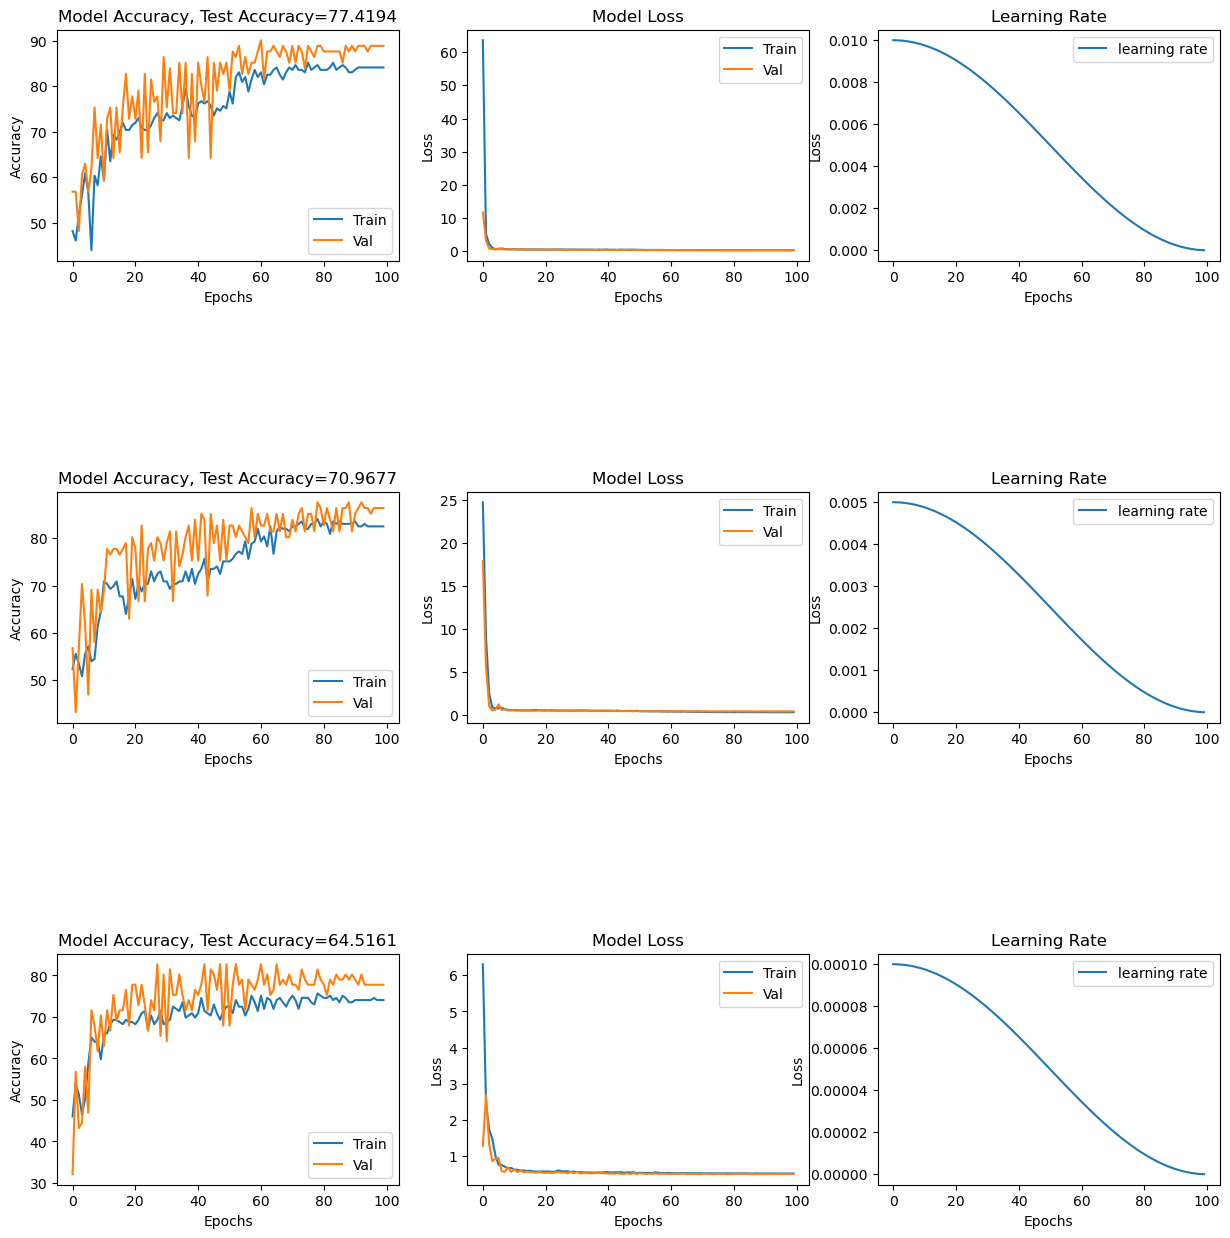

In [14]:
import matplotlib.pyplot as plt

lr_param = [1e-2, 5*1e-3, 1e-4]

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()

result = {"learning rate":[1e-2, 1e-2, 5*1e-3, 5*1e-3, 1e-4, 1e-4],
          "meaning":["Accuracy", "Loss", "Accuracy", "Loss", "Accuracy", "Loss"],
          "train":[],
          "val":[],
          "test":[]}

for i in range(3):
    
    model = Model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr_param[i])
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)
    history, test_accuracy, test_loss = experiment(model,
                                                   train_loader,
                                                   val_loader,
                                                   test_loader,
                                                   lr_scheduler,
                                                   optimizer)
    
    train_losses, val_losses, train_accuracies, val_accuracies, lr = history
    
    result["train"].append(train_accuracies[-1])
    result["train"].append(train_losses[-1])
    result["val"].append(val_accuracies[-1])
    result["val"].append(val_losses[-1])
    result["test"].append(test_accuracy)
    result["test"].append(test_loss)
    
    # Plotting training and validation accuracy
    ax[i*3].plot(train_accuracies)
    ax[i*3].plot(val_accuracies)
    ax[i*3].set_title(f'Model Accuracy, Test Accuracy={test_accuracy:.4f}')
    ax[i*3].set_xlabel('Epochs')
    ax[i*3].set_ylabel('Accuracy')
    ax[i*3].legend(['Train', 'Val'])

    # Plotting training and validation loss
    ax[i*3+1].plot(train_losses)
    ax[i*3+1].plot(val_losses)
    ax[i*3+1].set_title('Model Loss')
    ax[i*3+1].set_xlabel('Epochs')
    ax[i*3+1].set_ylabel('Loss')
    ax[i*3+1].legend(['Train', 'Val'])
    
    # Plotting Change of Learning Rate
    ax[i*3+2].plot(lr, label='learning rate')
    ax[i*3+2].set_title('Learning Rate')
    ax[i*3+2].set_xlabel('Epochs')
    ax[i*3+2].set_ylabel('Loss')
    ax[i*3+2].legend()
    
plt.subplots_adjust(wspace=0.2, hspace=1)

In [26]:
df = pd.DataFrame(result)
df = df.groupby(["learning rate", "meaning"]).mean().sort_values(["learning rate"], ascending=False)
df

train        val       test
learning rate meaning                                  
0.0100        Accuracy  84.126984  88.888889  77.419355
              Loss       0.348913   0.365703   0.523284
0.0050        Accuracy  82.539683  86.419753  70.967742
              Loss       0.359496   0.456174   0.519536
0.0001        Accuracy  74.074074  77.777778  64.516129
              Loss       0.519490   0.507223   0.655989

## Change Beta

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is 80.64516129032258%


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is 77.41935483870968%


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is 70.96774193548387%


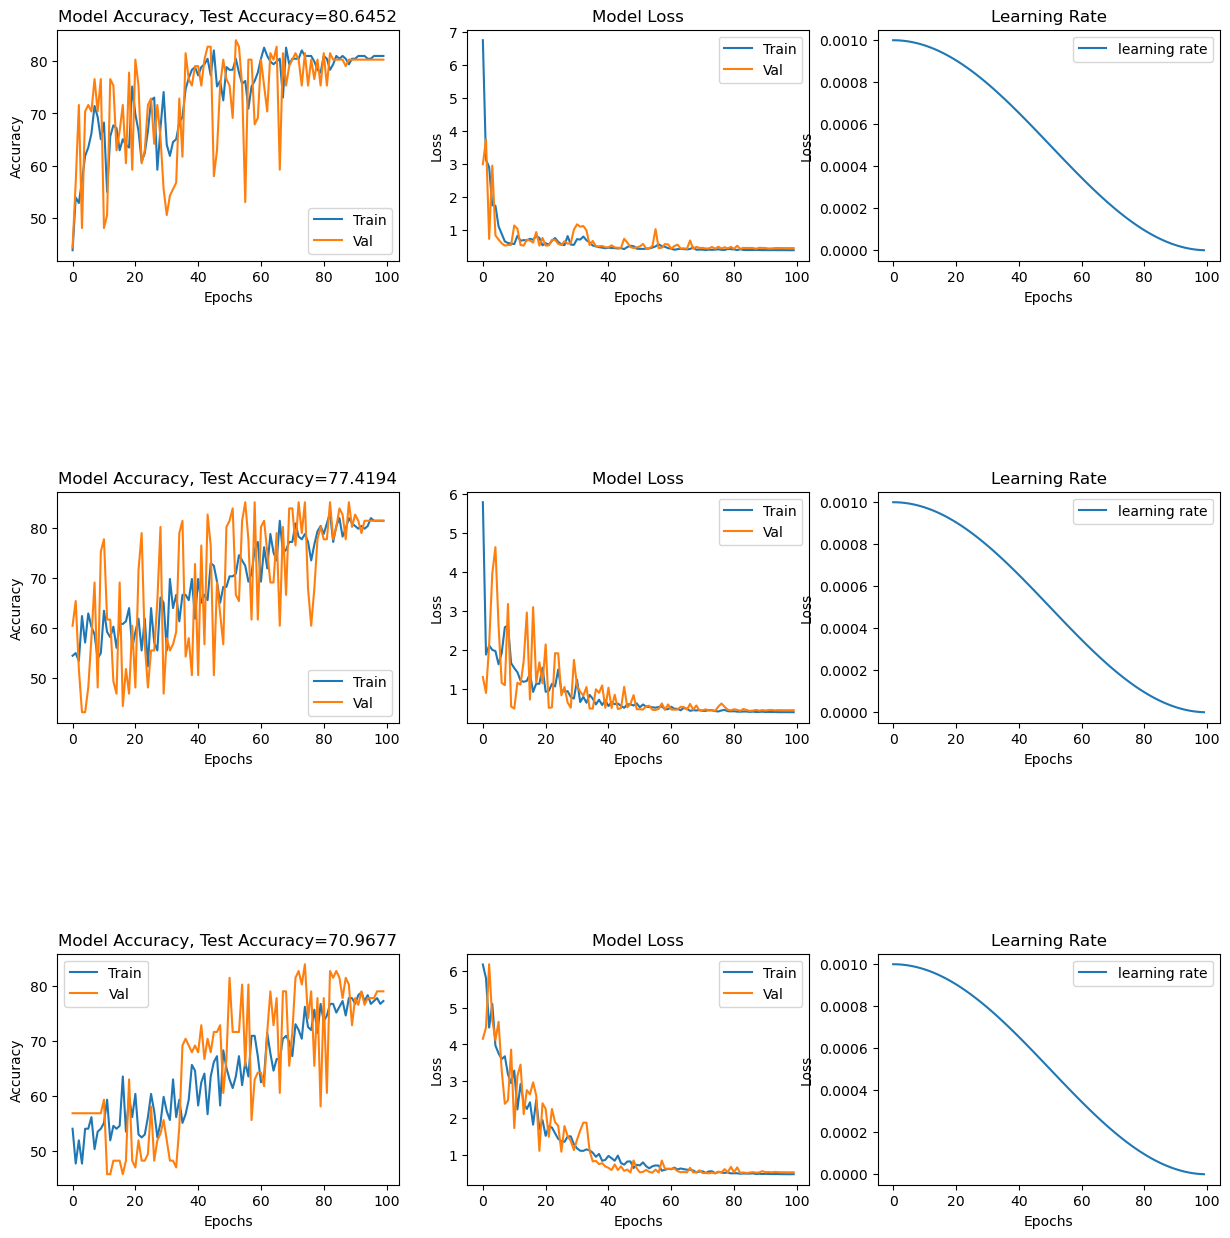

In [27]:
betas = [(0.9, 0.999), (0.5, 0.6), (0.1, 0.2)]
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()

result = {"beta":[(0.9, 0.95), (0.9, 0.95), (0.5, 0.6), (0.5, 0.6), (0.1, 0.2), (0.1, 0.2)],
          "meaning":["Accuracy", "Loss", "Accuracy", "Loss", "Accuracy", "Loss"],
          "train":[],
          "val":[],
          "test":[]}

for i in range(3):
    
    model = Model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=betas[i])
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)
    history, test_accuracy, test_loss = experiment(model,
                                        train_loader,
                                        val_loader,
                                        test_loader,
                                        lr_scheduler,
                                        optimizer)
    
    train_losses, val_losses, train_accuracies, val_accuracies, lr = history
    
    result["train"].append(train_accuracies[-1])
    result["train"].append(train_losses[-1])
    result["val"].append(val_accuracies[-1])
    result["val"].append(val_losses[-1])
    result["test"].append(test_accuracy)
    result["test"].append(test_loss)


    # Plotting training and validation accuracy
    ax[i*3].plot(train_accuracies)
    ax[i*3].plot(val_accuracies)
    ax[i*3].set_title(f'Model Accuracy, Test Accuracy={test_accuracy:.4f}')
    ax[i*3].set_xlabel('Epochs')
    ax[i*3].set_ylabel('Accuracy')
    ax[i*3].legend(['Train', 'Val'])

    # Plotting training and validation loss
    ax[i*3+1].plot(train_losses)
    ax[i*3+1].plot(val_losses)
    ax[i*3+1].set_title('Model Loss')
    ax[i*3+1].set_xlabel('Epochs')
    ax[i*3+1].set_ylabel('Loss')
    ax[i*3+1].legend(['Train', 'Val'])
    
    # Plotting Change of Learning Rate
    ax[i*3+2].plot(lr, label='learning rate')
    ax[i*3+2].set_title('Learning Rate')
    ax[i*3+2].set_xlabel('Epochs')
    ax[i*3+2].set_ylabel('Loss')
    ax[i*3+2].legend()
    
plt.subplots_adjust(wspace=0.2, hspace=1)

In [29]:
df = pd.DataFrame(result)
df = df.groupby(["beta", "meaning"]).mean()
df

train        val       test
beta        meaning                                  
(0.1, 0.2)  Accuracy  77.248677  79.012346  70.967742
            Loss       0.484936   0.535289   0.677392
(0.5, 0.6)  Accuracy  81.481481  81.481481  77.419355
            Loss       0.415134   0.466035   0.629062
(0.9, 0.95) Accuracy  80.952381  80.246914  80.645161
            Loss       0.389541   0.452979   0.575575

## Differences between Training Data and Testing Data

In [8]:
df_test = pd.read_csv('heart_dataset_test.csv')

df = pd.read_csv('heart_dataset_train_all.csv')

# one hot encoding
sex_description = {
    'Male': 0,
    'Female': 1,
}
df.loc[:, 'sex'] = df['sex'].map(sex_description)

# Mapping 'cp' (chest pain) descriptions to numbers
pain_description = {
    'low': 0,
    'medium': 1,
    'high': 2,
    'severe': 3
}
df.loc[:, 'cp'] = df['cp'].map(pain_description)

df_train = df.dropna()
features = df_train.columns

C:\Users\paddy\AppData\Local\Temp\ipykernel_25764\1463264663.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'sex'] = df['sex'].map(sex_description)
C:\Users\paddy\AppData\Local\Temp\ipykernel_25764\1463264663.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'cp'] = df['cp'].map(pain_description)


In [31]:
print(len(df_train), len(df_test))

270 31


In [44]:
df_train.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,54.385185,0.685185,0.962963,131.525926,245.607407,0.151852,0.522222,149.807407,0.333333,1.024074,1.400000,0.744444,2.300000,0.544444
std,9.149713,0.465305,1.023206,17.904675,51.529411,0.359544,0.529314,23.217253,0.472280,1.188379,0.618188,1.037166,0.623874,0.498946
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.250000,0.000000,0.000000,120.000000,210.250000,0.000000,0.000000,134.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.600000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.000000,0.000000,1.000000,167.750000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [45]:
df_test.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,55.193548,0.709677,1.032258,135.096774,251.806452,0.129032,0.580645,148.645161,0.322581,1.319355,1.354839,0.645161,2.483871,0.483871
std,8.332344,0.461414,1.139704,14.985226,57.526469,0.340777,0.501610,20.441051,0.475191,0.976872,0.660726,0.914636,0.508001,0.508001
min,40.000000,0.000000,0.000000,110.000000,172.000000,0.000000,0.000000,109.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,50.000000,0.000000,0.000000,126.000000,217.500000,0.000000,0.000000,134.500000,0.000000,0.550000,1.000000,0.000000,2.000000,0.000000
50%,58.000000,1.000000,0.000000,135.000000,234.000000,0.000000,1.000000,153.000000,0.000000,1.200000,1.000000,0.000000,2.000000,0.000000
75%,60.000000,1.000000,2.000000,147.500000,286.000000,0.000000,1.000000,162.500000,1.000000,2.000000,2.000000,1.000000,3.000000,1.000000
max,71.000000,1.000000,3.000000,170.000000,417.000000,1.000000,1.000000,179.000000,1.000000,3.400000,2.000000,3.000000,3.000000,1.000000


In [46]:
from scipy.stats import ks_2samp

for col in features:
    stat, p_value = ks_2samp(df_train[col], df_test[col])
    print(f"{col}: KS statistic = {stat:.4f}, p = {p_value:.4f}")

age: KS statistic = 0.1161, p = 0.8018
sex: KS statistic = 0.0245, p = 1.0000
cp: KS statistic = 0.0961, p = 0.9354
trestbps: KS statistic = 0.1765, p = 0.3109
chol: KS statistic = 0.1131, p = 0.8256
fbs: KS statistic = 0.0228, p = 1.0000
restecg: KS statistic = 0.0732, p = 0.9953
thalach: KS statistic = 0.0922, p = 0.9524
exang: KS statistic = 0.0108, p = 1.0000
oldpeak: KS statistic = 0.2646, p = 0.0328
slope: KS statistic = 0.0264, p = 1.0000
ca: KS statistic = 0.0535, p = 1.0000
thal: KS statistic = 0.1024, p = 0.9005
target: KS statistic = 0.0606, p = 0.9997


In [47]:
from scipy.stats import chi2_contingency

for col in ["sex", "cp"]:
    train_counts = df_train[col].value_counts()
    test_counts = df_test[col].value_counts()
    all_categories = set(train_counts.index).union(set(test_counts.index))

    train_freq = [train_counts.get(cat, 0) for cat in all_categories]
    test_freq = [test_counts.get(cat, 0) for cat in all_categories]

    stat, p_value, _, _ = chi2_contingency([train_freq, test_freq])
    print(f"{col}: Chi2 p = {p_value:.4f}")

sex: Chi2 p = 0.9409
cp: Chi2 p = 0.2153


## Feature Selection & Experiments

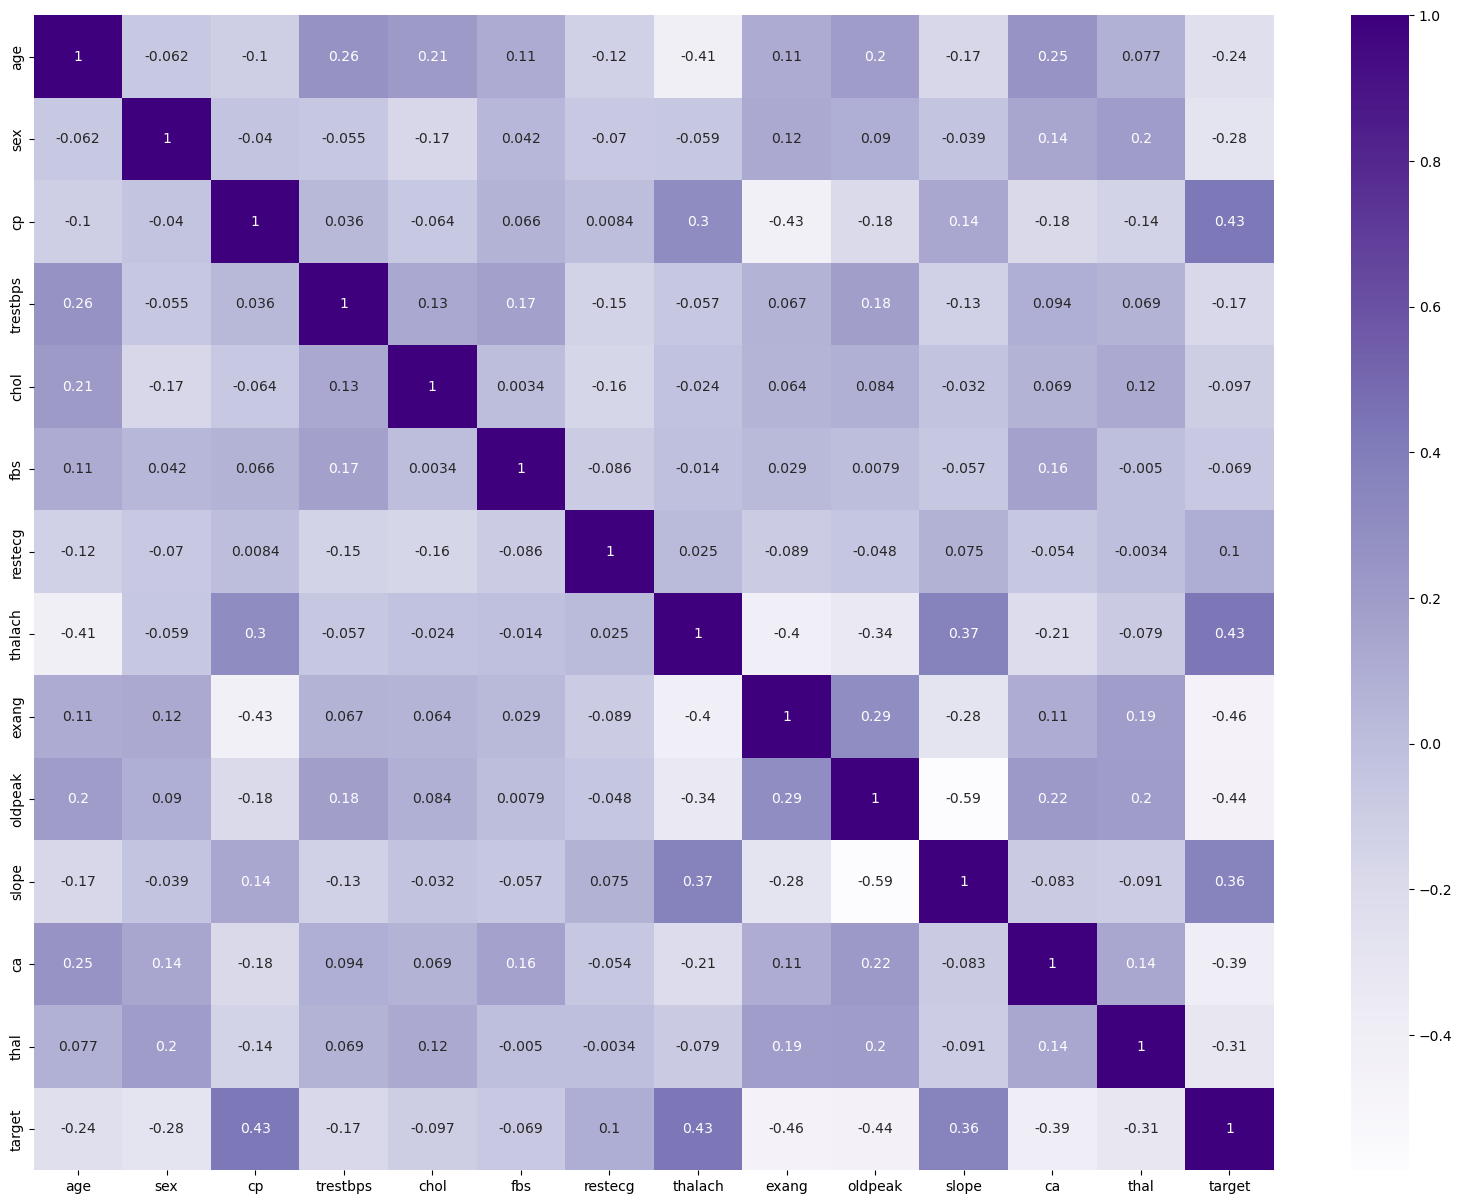

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(df_train.corr(), cmap="Purples", annot=True)

In [68]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE

X = df_train.drop(columns="target")
y = df_train["target"]

selector = SelectKBest(score_func=f_classif, k=10)  # Or use mutual_info_classif
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features.tolist())
selected_features = selected_features.tolist()

Selected features: ['age', 'sex', 'cp', 'trestbps', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [69]:
n = len(selected_features)
selected_features.append("target")
df = df_train[selected_features]
df = df.dropna()
# split train, validation data
np_data = df.values
print(np_data.shape)
split_point = int(np_data.shape[0]*0.7)

np.random.shuffle(np_data)

x_train = np_data[:split_point, :n]
y_train = np_data[:split_point, n]
x_val = np_data[split_point:, :n]
y_val = np_data[split_point:, n]

# trasform to Dataloader
x_train = np.array(x_train, dtype=float)
x_train = torch.from_numpy(x_train).float()
y_train = np.array(y_train, dtype=int)
y_train = torch.from_numpy(y_train).long()

x_val = np.array(x_val, dtype=float)
x_val = torch.from_numpy(x_val).float()
y_val = np.array(y_val, dtype=int)
y_val = torch.from_numpy(y_val).long()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

test_data = df_test[selected_features]
test_data = test_data.values
# Convert to PyTorch tensors
x_test = torch.from_numpy(test_data[:, :n]).float()
y_test = torch.from_numpy(test_data[:, n]).long()

# Create datasets
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

(270, 11)
Number of samples in train and validation are 189 and 81.


In [71]:
class Model(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_channel, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        return self.model(x)


model = Model(n).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)
histroy, test_accuracy = experiment(model,
                                    train_loader,
                                    val_loader,
                                    test_loader,
                                    lr_scheduler,
                                    optimizer)

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is 77.41935483870968%


In [23]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TabularTransformer(nn.Module):
    def __init__(self, num_features, d_model, nhead, num_layers, num_classes=1):
        super(TabularTransformer, self).__init__()
        self.feature_embedding = nn.Linear(1, d_model)  # or use Embedding for categorical
        self.pos_embedding = nn.Parameter(torch.randn(1, num_features, d_model))
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features * d_model, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x shape: [batch, num_features]
        x = x.unsqueeze(-1)  # [batch, num_features, 1]
        x = self.feature_embedding(x)  # [batch, num_features, d_model]
        x = x + self.pos_embedding  # Add positional embedding
        x = self.transformer(x)  # [batch, num_features, d_model]
        out = self.classifier(x)  # [batch, 1]
        return out
    


In [24]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = TabularTransformer(13, 256, 4, 1, num_classes=2)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0)
history, test_accuracy, test_loss = experiment(model,
                                    train_loader,
                                    val_loader,
                                    test_loader,
                                    lr_scheduler,
                                    optimizer,
                                   epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is 41.935483870967744%


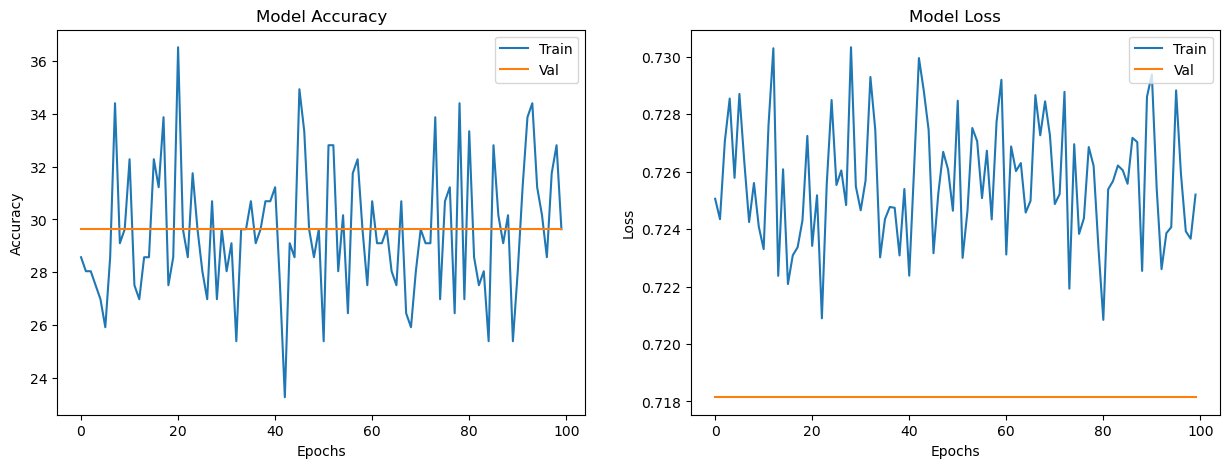

In [25]:
import matplotlib.pyplot as plt

train_losses, val_losses, train_accuracies, val_accuracies, _ = history
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()